# Passive membrane ODE – PINN vs Reference
This notebook loads a trained model and compares it to the analytical solution.



In [6]:
%matplotlib widget

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation
import torch
from torch import tensor

from examples.equations.membrane_ode.ode import reference_solution
from measure_uq.models import PINN, PINN_PCE
from measure_uq.pde import PDE
from measure_uq.trainers.trainer import Trainer
from measure_uq.utilities import to_numpy

mpl.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "STIX",
        "mathtext.fontset": "stix",
        "font.size": 16,
        "axes.titlesize": 16,
        "axes.labelsize": 16,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "figure.titlesize": 16,
    }
)

use_pce = False
if use_pce:
    model_type = PINN_PCE
    model_path = "data/best_model_pinn_pce.pickle"
    pde_path = "data/pde_pinn_pce.pickle"
    trainer_path = "data/trainer_pinn_pce.pickle"
else:
    model_type = PINN
    model_path = "data/best_model_pinn.pickle"
    pde_path = "data/pde_pinn.pickle"
    trainer_path = "data/trainer_pinn.pickle"

model = model_type.load(model_path)
pde = PDE.load(pde_path)
trainer = Trainer.load(trainer_path)

T = pde.conditions_train.conditions[0].T

t = tensor(np.linspace(0, T, 201)[:, None]).float()

pde.parameters_test.N = 5000
pde.parameters_test.sample_values()
parameters = pde.parameters_test.values.detach().cpu()

Nt = t.shape[0]
Np = parameters.shape[0]



In [7]:
_, y_tmp = model.forward(t, parameters)

y = np.array(
    [y_tmp[k::Np, :].detach().cpu().numpy() for k in range(Np)],
)  # shape: (samples, Nt, 1)

y = y.squeeze(-1)

mean_y = y.mean(axis=0)
std_y = y.std(axis=0)



In [11]:
tt = to_numpy(t).squeeze()

# Vectorized analytical solution for all parameter samples
# reference_solution returns shape (Nt, Np) when given all params; transpose to (Np, Nt)
solutions = reference_solution(tt, parameters.numpy()).T
mean_solution = solutions.mean(axis=0)
std_solution = solutions.std(axis=0)



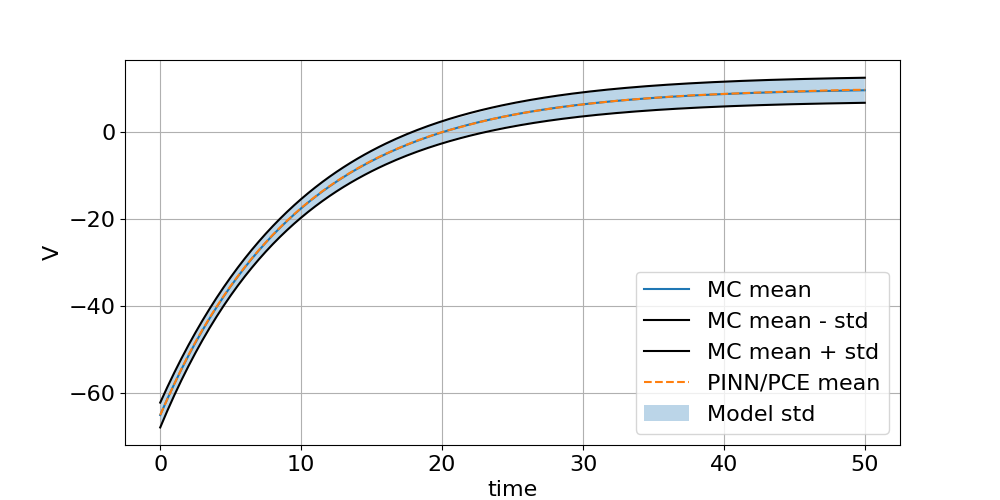

In [12]:
plt.close("all")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(t, mean_solution, label="MC mean")
ax.plot(t, mean_solution - std_solution, color="black", label="MC mean - std")
ax.plot(t, mean_solution + std_solution, color="black", label="MC mean + std")

ax.plot(t, mean_y, "--", label="PINN/PCE mean")
ax.fill_between(
    t.squeeze(),
    mean_y - std_y,
    mean_y + std_y,
    alpha=0.3,
    label="Model std",
)

ax.set_xlabel("time")
ax.set_ylabel("V")

ax.legend()
ax.grid()

fig.savefig("membrane_ode_mean_and_std.pdf", bbox_inches="tight", dpi=300)


In [13]:
tt = to_numpy(t).squeeze()
bins = np.linspace(-80, 20, 100)

fig, ax = plt.subplots(figsize=(8, 4))


def update(frame):
    ax.clear()

    ax.hist(
        solutions[:, frame],
        bins=bins,
        density=True,
        alpha=0.6,
        color="skyblue",
        label="Reference",
    )
    ax.hist(y[:, frame], bins=bins, density=True, alpha=0.6, color="red", label="Model")

    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylabel("Frequency")
    ax.set_xlabel("V")
    ax.set_title(f"t = {tt[frame]:.2f}")
    ax.legend()

    fig.tight_layout()


anime = animation.FuncAnimation(fig, update, frames=len(tt), interval=100)
plt.close()

HTML(anime.to_html5_video())


### Plot the train and test loss


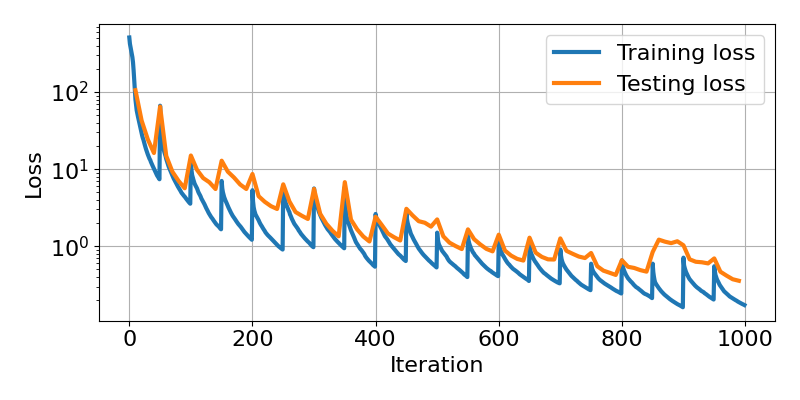

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

x1 = trainer.trainer_data.losses_train.i
y1 = trainer.trainer_data.losses_train.v
ax.plot(x1, y1, label="Training loss", linewidth=3)

x2 = trainer.trainer_data.losses_test.i
y2 = trainer.trainer_data.losses_test.v
ax.plot(x2, y2, label="Testing loss", linewidth=3)

ax.set_yscale("log")
ax.grid(True)

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend()

fig.tight_layout()

fig.savefig("membrane_ode_loss.pdf", bbox_inches="tight", dpi=300)


### Richer diagnostics and visuals
Below we add several informative plots:
- Quantile bands (5–95%) vs time comparing reference and model
- Waterfall of individual trajectories
- Phase dynamics: dV/dt vs V
- Time–voltage density heatmaps
- Violin plots at key times
- Interactive sliders for V_rest and I


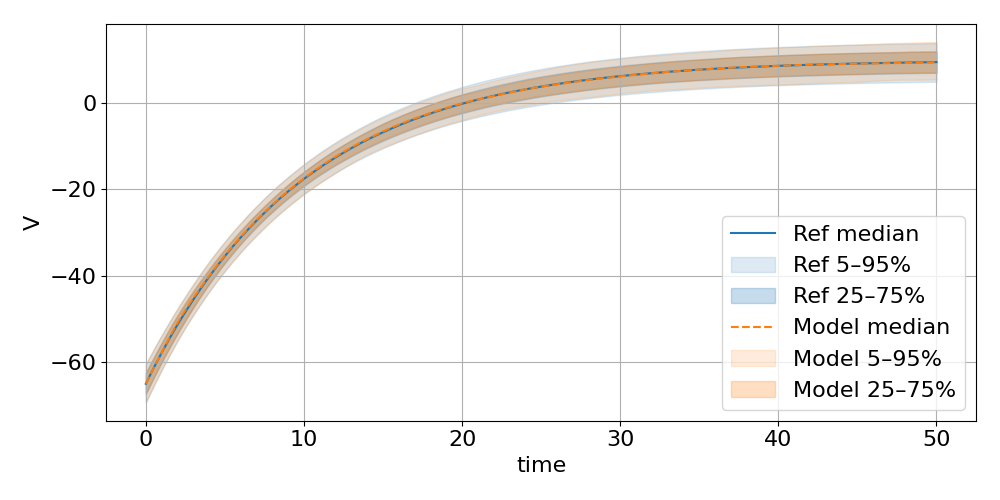

In [15]:
# Quantile bands against time (reference vs model)
quantiles = [5, 25, 50, 75, 95]
q_ref = np.percentile(solutions, quantiles, axis=0)
q_mod = np.percentile(y, quantiles, axis=0)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t, q_ref[2], label='Ref median', color='C0')
ax.fill_between(t.squeeze(), q_ref[0], q_ref[4], color='C0', alpha=0.15, label='Ref 5–95%')
ax.fill_between(t.squeeze(), q_ref[1], q_ref[3], color='C0', alpha=0.25, label='Ref 25–75%')

ax.plot(t, q_mod[2], '--', label='Model median', color='C1')
ax.fill_between(t.squeeze(), q_mod[0], q_mod[4], color='C1', alpha=0.15, label='Model 5–95%')
ax.fill_between(t.squeeze(), q_mod[1], q_mod[3], color='C1', alpha=0.25, label='Model 25–75%')

ax.set_xlabel('time')
ax.set_ylabel('V')
ax.legend(loc='best')
ax.grid(True)
fig.tight_layout()

fig.savefig('membrane_ode_quantile_bands.pdf', bbox_inches='tight', dpi=300)


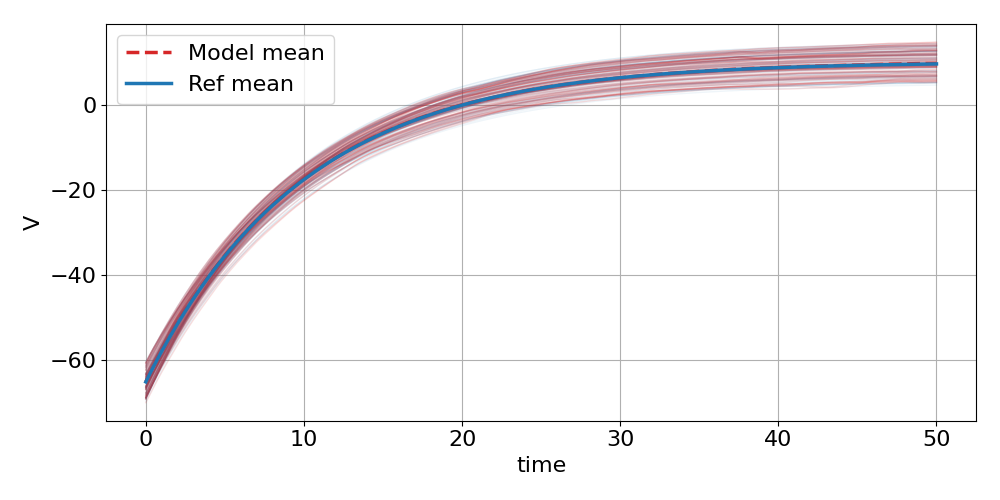

In [16]:
# Waterfall plot of individual trajectories (thin lines) with mean overlay
fig, ax = plt.subplots(figsize=(10, 5))
K = min(80, y.shape[0])
idx = np.random.default_rng(0).choice(y.shape[0], size=K, replace=False)
for i, k in enumerate(idx):
    ax.plot(t.squeeze(), y[k], color='tab:red', alpha=0.15, linewidth=1)
    ax.plot(t.squeeze(), solutions[k], color='tab:blue', alpha=0.07, linewidth=1)

ax.plot(t.squeeze(), mean_y, '--', color='tab:red', linewidth=2.5, label='Model mean')
ax.plot(t.squeeze(), mean_solution, color='tab:blue', linewidth=2.5, label='Ref mean')

ax.set_xlabel('time')
ax.set_ylabel('V')
ax.legend(loc='best')
ax.grid(True)
fig.tight_layout()

fig.savefig('membrane_ode_waterfall.pdf', bbox_inches='tight', dpi=300)


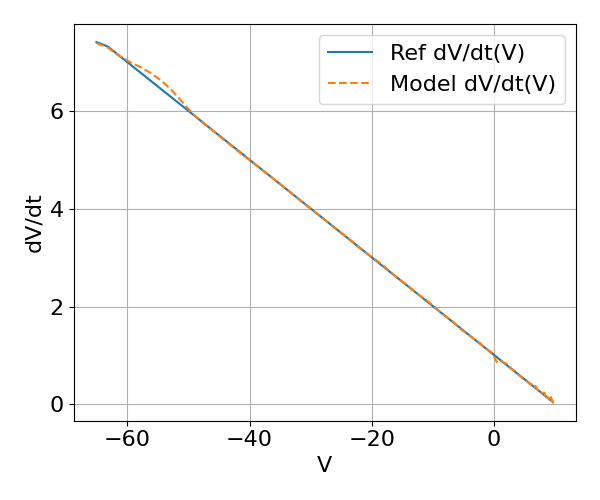

In [17]:
# Phase dynamics: dV/dt vs V for model and reference
# Compute time derivatives numerically
vv_mod = mean_y
vv_ref = mean_solution

dt = float(t[1] - t[0])
dvdt_mod = np.gradient(vv_mod, dt)
dvdt_ref = np.gradient(vv_ref, dt)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(vv_ref, dvdt_ref, label='Ref dV/dt(V)', color='C0')
ax.plot(vv_mod, dvdt_mod, '--', label='Model dV/dt(V)', color='C1')
ax.set_xlabel('V')
ax.set_ylabel('dV/dt')
ax.grid(True)
ax.legend(loc='best')
fig.tight_layout()

fig.savefig('membrane_ode_phase_dynamics.pdf', bbox_inches='tight', dpi=300)


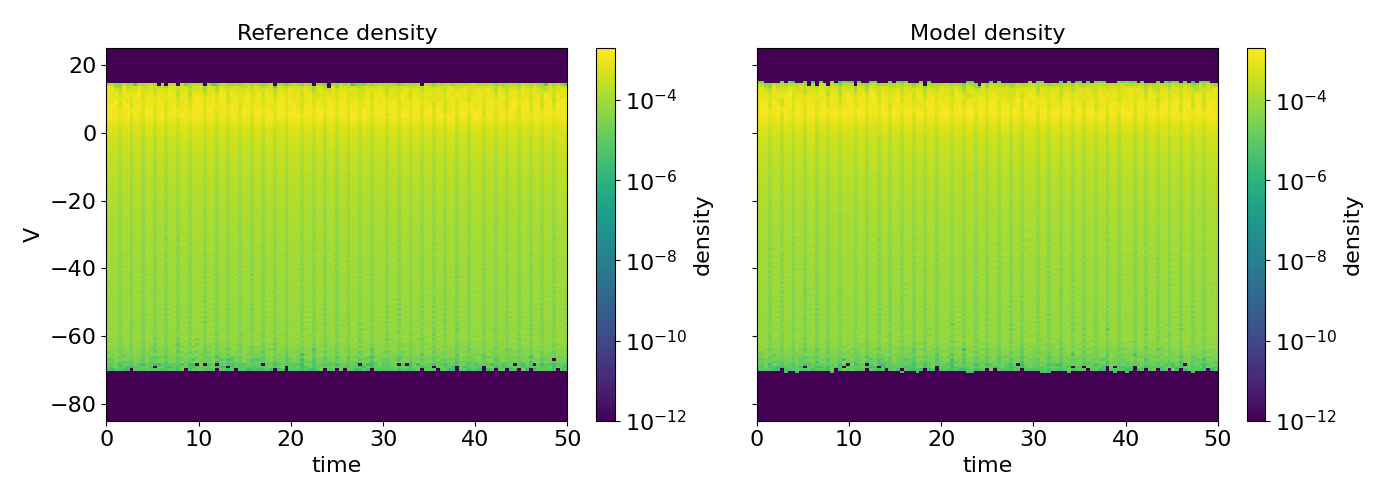

In [18]:
# Time–voltage density heatmaps for reference and model
from matplotlib.colors import LogNorm

bins_v = np.linspace(-85, 25, 150)
bins_t = np.linspace(float(t.min()), float(t.max()), 120)

H_ref, xedges, yedges = np.histogram2d(
    np.repeat(t.squeeze(), solutions.shape[0]),
    solutions.flatten(),
    bins=[bins_t, bins_v],
    density=True,
)
H_mod, _, _ = np.histogram2d(
    np.repeat(t.squeeze(), y.shape[0]),
    y.flatten(),
    bins=[bins_t, bins_v],
    density=True,
)

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
im0 = axs[0].pcolormesh(xedges, yedges, H_ref.T + 1e-12, shading='auto', norm=LogNorm())
im1 = axs[1].pcolormesh(xedges, yedges, H_mod.T + 1e-12, shading='auto', norm=LogNorm())
axs[0].set_title('Reference density')
axs[1].set_title('Model density')
for a in axs:
    a.set_xlabel('time')
axs[0].set_ylabel('V')
fig.colorbar(im0, ax=axs[0], label='density')
fig.colorbar(im1, ax=axs[1], label='density')
fig.tight_layout()

fig.savefig('membrane_ode_density_heatmaps.pdf', bbox_inches='tight', dpi=300)


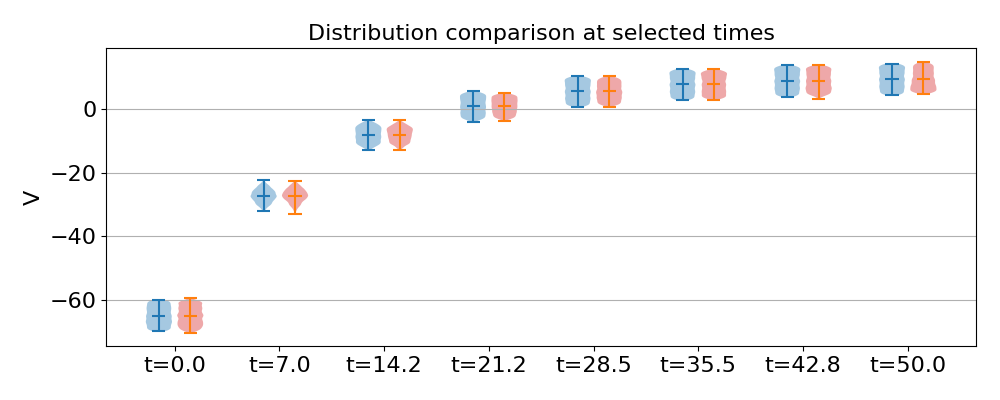

In [19]:
# Violin plots at selected times
fig, ax = plt.subplots(figsize=(10, 4))
selected_idx = np.linspace(0, len(tt) - 1, 8, dtype=int)
parts1 = ax.violinplot([solutions[:, i] for i in selected_idx], positions=np.arange(len(selected_idx)) - 0.15, widths=0.25, showmeans=True)
parts2 = ax.violinplot([y[:, i] for i in selected_idx], positions=np.arange(len(selected_idx)) + 0.15, widths=0.25, showmeans=True)

for pc in parts1['bodies']:
    pc.set_facecolor('tab:blue'); pc.set_alpha(0.4)
for pc in parts2['bodies']:
    pc.set_facecolor('tab:red'); pc.set_alpha(0.4)

ax.set_xticks(np.arange(len(selected_idx)))
ax.set_xticklabels([f"t={tt[i]:.1f}" for i in selected_idx], rotation=0)
ax.set_ylabel('V')
ax.set_title('Distribution comparison at selected times')
ax.grid(True, axis='y')
fig.tight_layout()

fig.savefig('membrane_ode_violins.pdf', bbox_inches='tight', dpi=300)


interactive(children=(FloatSlider(value=-65.0, description='V_rest', max=-50.0, min=-80.0, step=0.5), FloatSli…

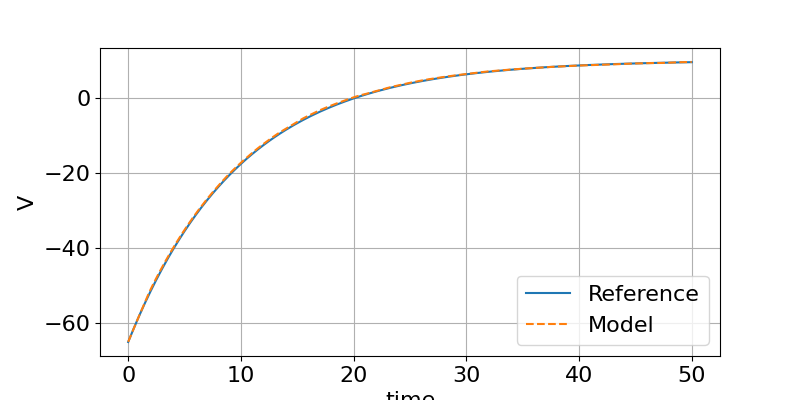

In [20]:
# Interactive exploration: slider for V_rest and I
import ipywidgets as widgets
from ipywidgets import HBox, VBox

def simulate_reference(v_rest: float, I: float) -> np.ndarray:
    p = np.array([[v_rest, I]])
    return reference_solution(tt, p)

def simulate_model(v_rest: float, I: float) -> np.ndarray:
    # build a single-parameter tensor and run the model
    p = tensor([[v_rest, I]]).float()
    with torch.no_grad():
        _, y1 = model.forward(t, p)
    return y1.squeeze(-1).detach().cpu().numpy()

v_rest_slider = widgets.FloatSlider(value=-65.0, min=-80.0, max=-50.0, step=0.5, description='V_rest')
I_slider = widgets.FloatSlider(value=2.0, min=0.0, max=5.0, step=0.1, description='I')

fig, ax = plt.subplots(figsize=(8, 4))
line_ref, = ax.plot(tt, simulate_reference(v_rest_slider.value, I_slider.value), label='Reference')
line_mod, = ax.plot(tt, simulate_model(v_rest_slider.value, I_slider.value), '--', label='Model')
ax.set_xlabel('time')
ax.set_ylabel('V')
ax.legend(); ax.grid(True)

out = widgets.Output()

@widgets.interact(v_rest=v_rest_slider, I=I_slider)
def update(v_rest, I):
    line_ref.set_ydata(simulate_reference(v_rest, I))
    line_mod.set_ydata(simulate_model(v_rest, I))
    fig.canvas.draw_idle()
    return None

VBox([out])


In [ ]:
# Residual over time for ODE residual condition (model vs analytical)
from examples.equations.membrane_ode.ode import Residual as ResidualCond

# Build a synthetic residual condition using the same T and tau, R as in training defaults
cond = pde.conditions_train.conditions[0]
assert isinstance(cond, ResidualCond)

with torch.no_grad():
    txp, yp = model.forward(t, parameters[:50])  # use a subset for speed
    # txp columns are [t, V_rest, I] per this ODE setup
    r_model = cond.eval(txp, yp).detach().cpu().numpy().reshape(-1)

# For the reference residual, feed exact solution at the same inputs
p_sub = parameters[:50]
txp_ref = model.combine_input(t, p_sub)
y_ref = tensor(reference_solution(tt, p_sub.numpy()).reshape(-1, 1)).float()
with torch.no_grad():
    r_ref = cond.eval(txp_ref, y_ref).detach().cpu().numpy().reshape(-1)

# Average absolute residual per time index
Nt = t.shape[0]
Np_sub = p_sub.shape[0]
r_model_t = np.abs(r_model).reshape(Nt, Np_sub).mean(axis=1)
r_ref_t = np.abs(r_ref).reshape(Nt, Np_sub).mean(axis=1)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(tt, r_model_t, label='Model residual (avg |r|)')
ax.plot(tt, r_ref_t, label='Ref residual (avg |r|)')
ax.set_yscale('log')
ax.set_xlabel('time')
ax.set_ylabel('Residual')
ax.grid(True)
ax.legend()
fig.tight_layout()

fig.savefig('membrane_ode_residual_over_time.pdf', bbox_inches='tight', dpi=300)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### Interactive parameter explorer (trajectory + vector field)
Use sliders to change `V_rest`, `I`, and the physical parameters `tau`, `R` for the analytical solution. The model prediction is shown for the chosen `V_rest`, `I` (model was trained with fixed `tau=10`, `R=5`). The right plot shows the phase dynamics dV/dt vs V and the nullcline V = R I.


interactive(children=(FloatSlider(value=-65.0, description='V_rest', max=-50.0, min=-80.0, step=0.5), FloatSli…

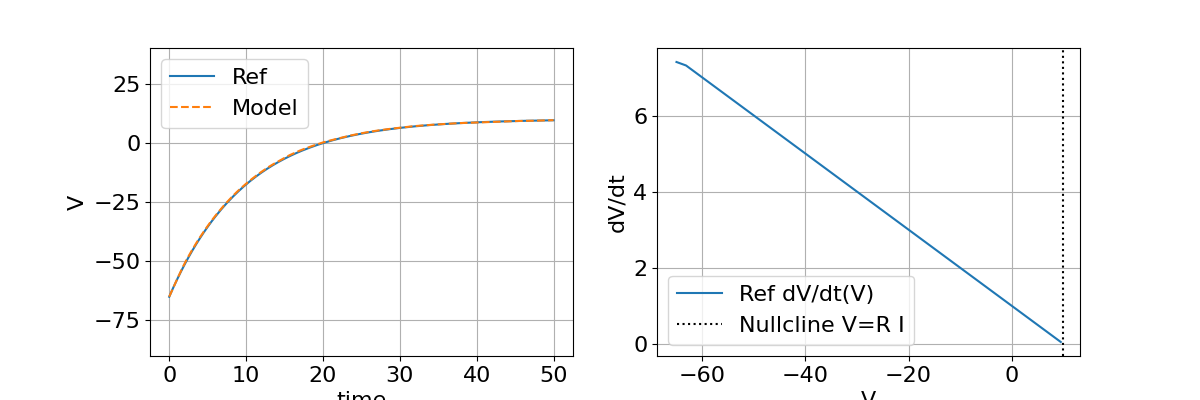

In [ ]:
# Interactive: trajectory + phase plot with sliders
import ipywidgets as widgets

# Fixed time grid from earlier cell: t, tt
# Analytical with adjustable tau, R

def reference_solution_params(tt: np.ndarray, v_rest: float, I: float, tau: float, R: float) -> np.ndarray:
    if tt.ndim == 1:
        tt2 = tt[:, None]
    else:
        tt2 = tt
    return R * I + (v_rest - R * I) * np.exp(-tt2 / tau)

vmin, vmax = -90.0, 40.0

v_rest_w = widgets.FloatSlider(value=-65.0, min=-80.0, max=-50.0, step=0.5, description='V_rest')
I_w = widgets.FloatSlider(value=2.0, min=0.0, max=5.0, step=0.1, description='I')
tau_w = widgets.FloatSlider(value=10.0, min=1.0, max=50.0, step=0.5, description='tau')
R_w = widgets.FloatSlider(value=5.0, min=0.5, max=20.0, step=0.5, description='R')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left: trajectory
(line_ref_traj,) = axs[0].plot(tt, reference_solution_params(tt, v_rest_w.value, I_w.value, tau_w.value, R_w.value), label='Ref', color='C0')
with torch.no_grad():
    _, y1 = model.forward(t, tensor([[v_rest_w.value, I_w.value]]).float())
(line_mod_traj,) = axs[0].plot(tt, y1.squeeze(-1).detach().cpu().numpy(), '--', label='Model', color='C1')
axs[0].set_xlabel('time')
axs[0].set_ylabel('V')
axs[0].grid(True)
axs[0].legend(loc='best')
axs[0].set_ylim(vmin, vmax)

# Right: phase dynamics (dV/dt vs V) + nullcline
vv = reference_solution_params(tt, v_rest_w.value, I_w.value, tau_w.value, R_w.value).squeeze()
dt_ = tt[1] - tt[0]
dvdt_ref = np.gradient(vv, dt_)
(line_ref_phase,) = axs[1].plot(vv, dvdt_ref, color='C0', label='Ref dV/dt(V)')
axs[1].axvline(R_w.value * I_w.value, color='k', linestyle=':', label='Nullcline V=R I')
axs[1].set_xlabel('V')
axs[1].set_ylabel('dV/dt')
axs[1].legend(loc='best')
axs[1].grid(True)

@widgets.interact(V_rest=v_rest_w, I=I_w, tau=tau_w, R=R_w)
def _update(V_rest, I, tau, R):
    # Update trajectory
    v_ref = reference_solution_params(tt, V_rest, I, tau, R).squeeze()
    line_ref_traj.set_ydata(v_ref)
    with torch.no_grad():
        _, y1 = model.forward(t, tensor([[V_rest, I]]).float())
    line_mod_traj.set_ydata(y1.squeeze(-1).detach().cpu().numpy())
    axs[0].set_ylim(vmin, vmax)

    # Update phase and nullcline
    dvdt_ref = np.gradient(v_ref, dt_)
    line_ref_phase.set_xdata(v_ref)
    line_ref_phase.set_ydata(dvdt_ref)

    # Replace the nullcline line (single vertical line)
    axs[1].lines = [line_ref_phase]  # keep the phase line
    axs[1].axvline(R * I, color='k', linestyle=':', label='Nullcline V=R I')

    fig.canvas.draw_idle()
    return None

widgets.VBox([v_rest_w, I_w, tau_w, R_w])


### Interactive density heatmap over time
Adjust parameter ranges and sample size to see how the time–voltage density evolves for both the analytical solution and the model. You can change the number of bins, colormap, and turn log-scaling on/off.


In [ ]:
# Interactive: density heatmaps with parameter range controls
plt.close('all')
import ipywidgets as widgets
from matplotlib.colors import LogNorm, Normalize

# Widgets for sampling
vmin_w = widgets.FloatSlider(value=-80.0, min=-100.0, max=-40.0, step=1.0, description='Vmin')
vmax_w = widgets.FloatSlider(value=-60.0, min=-100.0, max=-40.0, step=1.0, description='Vmax')
Imin_w = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='Imin')
Imax_w = widgets.FloatSlider(value=3.0, min=0.0, max=5.0, step=0.1, description='Imax')
Nsamples_w = widgets.IntSlider(value=800, min=50, max=5000, step=50, description='Samples')
nbins_t_w = widgets.IntSlider(value=100, min=20, max=200, step=5, description='Bins t')
nbins_v_w = widgets.IntSlider(value=120, min=20, max=200, step=5, description='Bins V')
cmap_w = widgets.Dropdown(options=sorted(plt.colormaps()), value='viridis', description='Colormap')
logscale_w = widgets.Checkbox(value=True, description='Log scale')

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

@widgets.interact(vmin=vmin_w, vmax=vmax_w, Imin=Imin_w, Imax=Imax_w, N=Nsamples_w, bt=nbins_t_w, bv=nbins_v_w, cmap=cmap_w, log=logscale_w)
def _update_heatmap(vmin, vmax, Imin, Imax, N, bt, bv, cmap, log):
    axs[0].clear(); axs[1].clear()

    # sample parameters
    rng = np.random.default_rng(0)
    v0 = rng.uniform(vmin, vmax, size=(N, 1))
    I = rng.uniform(Imin, Imax, size=(N, 1))
    P = np.concatenate([v0, I], axis=1)

    # Compute solutions
    sol_ref = reference_solution(tt, P).T  # (N, Nt)
    with torch.no_grad():
        _, ypred = model.forward(t, tensor(P).float())
    sol_mod = ypred.view(N, -1).detach().cpu().numpy()

    # Build histograms
    bins_t = np.linspace(float(tt.min()), float(tt.max()), bt)
    bins_v = np.linspace(-90.0, 40.0, bv)
    H_ref, xedges, yedges = np.histogram2d(np.repeat(tt, N), sol_ref.flatten(), bins=[bins_t, bins_v], density=True)
    H_mod, _, _ = np.histogram2d(np.repeat(tt, N), sol_mod.flatten(), bins=[bins_t, bins_v], density=True)

    norm = LogNorm() if log else Normalize()
    im0 = axs[0].pcolormesh(xedges, yedges, (H_ref.T + 1e-12), shading='auto', norm=norm, cmap=cmap)
    im1 = axs[1].pcolormesh(xedges, yedges, (H_mod.T + 1e-12), shading='auto', norm=norm, cmap=cmap)

    axs[0].set_title('Reference density')
    axs[1].set_title('Model density')
    for a in axs:
        a.set_xlabel('time')
    axs[0].set_ylabel('V')

    fig.colorbar(im0, ax=axs[0], label='density')
    fig.colorbar(im1, ax=axs[1], label='density')
    fig.tight_layout()

widgets.VBox([vmin_w, vmax_w, Imin_w, Imax_w, Nsamples_w, nbins_t_w, nbins_v_w, cmap_w, logscale_w])
